# End-to-end Sequence Labeling via Bi-directional LSTM-CNNs-CRF

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd '/content/drive/MyDrive/CZ4045NLP/Assignment2/Q2'

In this tutorial we will demonstrate how to implement a state of the art  Bi-directional LSTM-CNN-CRF architecture (Published at ACL'16. [Link To Paper](http://www.aclweb.org/anthology/P16-1101)) for Named Entity Recognition using Pytorch. 

The main aim of the tutorial is to make the audience comfortable with pytorch using this tutorial and give a step-by-step walk through of the Bi-LSTM-CNN-CRF architecture for NER. Some familiarity with pytorch (or any other deep learning framework) would definitely be a plus. 

The agenda of this tutorial is as follows:

1. Getting Ready with the data 
2. Network Definition. This includes
    * CNN Encoder for Character Level representation.
    * Bi-directional LSTM for Word-Level Encoding.
    * Conditional Random Fields(CRF) for output decoding
3. Training 
4. Model testing

This tutorial draws its content/design heavily from [this](https://github.com/ZhixiuYe/NER-pytorch) Github implementation of NER model. We reuse their data preprocessing/Model creation methodology. This helps in focussing more on explaining model architecture and it's translation from formulae to code. 

**Authors:**
[**Anirudh Ganesh**](https://www.linkedin.com/in/anirudh-ganesh95/),
[**Peddamail Jayavardhan Reddy**](https://www.linkedin.com/in/jayavardhan-reddy-peddamail-6b4125a0/)

### Data Preparation

The paper uses the English data from CoNLL 2003 shared task\[1\], which is present in the "data" directory of this project. We will later apply more preprocessing steps to generate tag mapping, word mapping and character  mapping. The data set contains four different types of named entities: PERSON, LOCATION, ORGANIZATION, and MISC and uses the BIO tagging scheme

BIO tagging Scheme:

    I - Word is inside a phrase of type TYPE
    B - If two phrases of the same type immediately follow each other, the first word of the second phrase will have tag B-TYPE 
    O - Word is not part of a phrase
    
Example of English-NER sentence available in the data:
    
    U.N.         NNP  I-NP  I-ORG 
    official     NN   I-NP  O 
    Ekeus        NNP  I-NP  I-PER 
    heads        VBZ  I-VP  O 
    for          IN   I-PP  O 
    Baghdad      NNP  I-NP  I-LOC 
    .            .    O     O 
    
Data Split(We use the same split as mentioned in paper):

    Training Data - eng.train
    Validation Data - eng.testa
    Testing Data - eng.testb
    

 To get started we first import the necessary libraries

In [2]:
from __future__ import print_function
from collections import OrderedDict

import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
from torch import autograd

import time
import _pickle as cPickle

import urllib
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 80
plt.style.use('seaborn-pastel')

import os
import sys
import codecs
import re
import numpy as np

In [3]:
#Check whether running on GPU
torch.cuda.is_available()

True

##### Define constants and paramaters

We now define some constants and parameters that we will be using later

In [4]:
#parameters for the Model
parameters = OrderedDict()
parameters['train'] = "./data/eng.train" #Path to train file
parameters['dev'] = "./data/eng.testa" #Path to test file
parameters['test'] = "./data/eng.testb" #Path to dev file
parameters['tag_scheme'] = "BIOES" #BIO or BIOES
parameters['lower'] = True # Boolean variable to control lowercasing of words
parameters['zeros'] =  True # Boolean variable to control replacement of  all digits by 0 
parameters['char_dim'] = 30 #Char embedding dimension
parameters['word_dim'] = 100 #Token embedding dimension
parameters['word_lstm_dim'] = 200 #Token LSTM hidden layer size
parameters['word_bidirect'] = True #Use a bidirectional LSTM for words
parameters['embedding_path'] = "./data/glove.6B.100d.txt" #Location of pretrained embeddings
parameters['all_emb'] = 1 #Load all embeddings
parameters['crf'] =1 #Use CRF (0 to disable)
parameters['dropout'] = 0.5 #Droupout on the input (0 = no dropout)
parameters['epoch'] =  50 #Number of epochs to run"
parameters['weights'] = "" #path to Pretrained for from a previous run
#parameters['name'] = "self-trained-model" # Model name
parameters['name'] = "1-layer-CNN-model-conv2d-maxpool" # Model name

parameters['gradient_clip']=5.0
parameters['char_mode']="CNN"
models_path = "./models/" #path to saved models

#GPU
parameters['use_gpu'] = torch.cuda.is_available() #GPU Check
use_gpu = parameters['use_gpu']

parameters['reload'] = "./models/pre-trained-model" 
#Constants
START_TAG = '<START>'
STOP_TAG = '<STOP>'

In [5]:
#paths to files 
#To stored mapping file
mapping_file = './data/mapping.pkl'

#To stored model
name = parameters['name']
model_name = models_path + name #get_name(parameters)

if not os.path.exists(models_path):
    os.makedirs(models_path)

##### Load data and preprocess

Firstly, the data is loaded from the train, dev and test files into a list of sentences.

Preprocessing:

    * All the digits in the words are replaced by 0
    
Why this preprocessing step?
    * For the Named Entity Recognition task, the information present in numerical digits doesnot help in predicting the entity. So, we replace all the digits by 0. So, now the model can concentrate on more important alphabets.

In [6]:
def zero_digits(s):
    """
    Replace every digit in a string by a zero.
    """
    return re.sub('\d', '0', s)

def load_sentences(path, zeros):
    """
    Load sentences. A line must contain at least a word and its tag.
    Sentences are separated by empty lines.
    """
    sentences = []
    sentence = []
    for line in codecs.open(path, 'r', 'utf8'):
        line = zero_digits(line.rstrip()) if zeros else line.rstrip()
        if not line:
            if len(sentence) > 0:
                if 'DOCSTART' not in sentence[0][0]:
                    sentences.append(sentence)
                sentence = []
        else:
            word = line.split()
            assert len(word) >= 2
            sentence.append(word)
    if len(sentence) > 0:
        if 'DOCSTART' not in sentence[0][0]:
            sentences.append(sentence)
    return sentences

In [7]:
train_sentences = load_sentences(parameters['train'], parameters['zeros'])
test_sentences = load_sentences(parameters['test'], parameters['zeros'])
dev_sentences = load_sentences(parameters['dev'], parameters['zeros'])

##### Update tagging scheme

Different types of tagging schemes can be used for NER. We update the tags for train, test and dev data ( depending on the parameters \[ tag_scheme \] ).

In the paper, the authors use the tagging Scheme ( BIOES ) rather than BIO (which is used by the dataset). So, we need to first update the data to convert tag scheme from BIO to BIOES.

BIOES tagging scheme:

    I - Word is inside a phrase of type TYPE
    B - If two phrases of the same type immediately follow each other, the first word of the second phrase will have tag B-TYPE 
    O - Word is not part of a phrase
    E - End ( E will not appear in a prefix-only partial match )
    S - Single

In [8]:
def iob2(tags):
    """
    Check that tags have a valid BIO format.
    Tags in BIO1 format are converted to BIO2.
    """
    for i, tag in enumerate(tags):
        if tag == 'O':
            continue
        split = tag.split('-')
        if len(split) != 2 or split[0] not in ['I', 'B']:
            return False
        if split[0] == 'B':
            continue
        elif i == 0 or tags[i - 1] == 'O':  # conversion IOB1 to IOB2
            tags[i] = 'B' + tag[1:]
        elif tags[i - 1][1:] == tag[1:]:
            continue
        else:  # conversion IOB1 to IOB2
            tags[i] = 'B' + tag[1:]
    return True

def iob_iobes(tags):
    """
    the function is used to convert
    BIO -> BIOES tagging
    """
    new_tags = []
    for i, tag in enumerate(tags):
        if tag == 'O':
            new_tags.append(tag)
        elif tag.split('-')[0] == 'B':
            if i + 1 != len(tags) and \
               tags[i + 1].split('-')[0] == 'I':
                new_tags.append(tag)
            else:
                new_tags.append(tag.replace('B-', 'S-'))
        elif tag.split('-')[0] == 'I':
            if i + 1 < len(tags) and \
                    tags[i + 1].split('-')[0] == 'I':
                new_tags.append(tag)
            else:
                new_tags.append(tag.replace('I-', 'E-'))
        else:
            raise Exception('Invalid IOB format!')
    return new_tags

def update_tag_scheme(sentences, tag_scheme):
    """
    Check and update sentences tagging scheme to BIO2
    Only BIO1 and BIO2 schemes are accepted for input data.
    """
    for i, s in enumerate(sentences):
        tags = [w[-1] for w in s]
        # Check that tags are given in the BIO format
        if not iob2(tags):
            s_str = '\n'.join(' '.join(w) for w in s)
            raise Exception('Sentences should be given in BIO format! ' +
                            'Please check sentence %i:\n%s' % (i, s_str))
        if tag_scheme == 'BIOES':
            new_tags = iob_iobes(tags)
            for word, new_tag in zip(s, new_tags):
                word[-1] = new_tag
        else:
            raise Exception('Wrong tagging scheme!')

In [9]:
update_tag_scheme(train_sentences, parameters['tag_scheme'])
update_tag_scheme(dev_sentences, parameters['tag_scheme'])
update_tag_scheme(test_sentences, parameters['tag_scheme'])

##### Create Mappings for Words, Characters and Tags

After we have updated the tag scheme. We now have a list of sentences which are words along with their modified tags. Now, we want to map these individual words, tags and characters in each word, to unique numerical ID's so that each unique word, character and tag in the vocabulary is represented by a particular integer ID. To do this, we first create a functions that do these mapping for us

##### Why mapping is important?

These indices for words, tags and characters help us employ matrix (tensor) operations inside the neural network architecture, which are considerably faster.

In [10]:
def create_dico(item_list):
    """
    Create a dictionary of items from a list of list of items.
    """
    assert type(item_list) is list
    dico = {}
    for items in item_list:
        for item in items:
            if item not in dico:
                dico[item] = 1
            else:
                dico[item] += 1
    return dico

def create_mapping(dico):
    """
    Create a mapping (item to ID / ID to item) from a dictionary.
    Items are ordered by decreasing frequency.
    """
    sorted_items = sorted(dico.items(), key=lambda x: (-x[1], x[0]))
    id_to_item = {i: v[0] for i, v in enumerate(sorted_items)}
    item_to_id = {v: k for k, v in id_to_item.items()}
    return item_to_id, id_to_item

def word_mapping(sentences, lower):
    """
    Create a dictionary and a mapping of words, sorted by frequency.
    """
    words = [[x[0].lower() if lower else x[0] for x in s] for s in sentences]
    dico = create_dico(words)
    dico['<UNK>'] = 10000000 #UNK tag for unknown words
    word_to_id, id_to_word = create_mapping(dico)
    print("Found %i unique words (%i in total)" % (
        len(dico), sum(len(x) for x in words)
    ))
    return dico, word_to_id, id_to_word

def char_mapping(sentences):
    """
    Create a dictionary and mapping of characters, sorted by frequency.
    """
    chars = ["".join([w[0] for w in s]) for s in sentences]
    dico = create_dico(chars)
    char_to_id, id_to_char = create_mapping(dico)
    print("Found %i unique characters" % len(dico))
    return dico, char_to_id, id_to_char

def tag_mapping(sentences):
    """
    Create a dictionary and a mapping of tags, sorted by frequency.
    """
    tags = [[word[-1] for word in s] for s in sentences]
    dico = create_dico(tags)
    dico[START_TAG] = -1
    dico[STOP_TAG] = -2
    tag_to_id, id_to_tag = create_mapping(dico)
    print("Found %i unique named entity tags" % len(dico))
    return dico, tag_to_id, id_to_tag

In [11]:
dico_words,word_to_id,id_to_word = word_mapping(train_sentences, parameters['lower'])
dico_chars, char_to_id, id_to_char = char_mapping(train_sentences)
dico_tags, tag_to_id, id_to_tag = tag_mapping(train_sentences)

Found 17493 unique words (203621 in total)
Found 75 unique characters
Found 19 unique named entity tags


##### Preparing final dataset

The function prepare dataset returns a list of dictionaries ( one dictionary per each sentence )

Each of the dictionary returned by the function contains
    1. list of all words in the sentence
    2. list of word index for all words in the sentence
    3. list of lists, containing character id of each character for words in the sentence
    4. list of tag for each word in the sentence.

In [12]:
def lower_case(x,lower=False):
    if lower:
        return x.lower()  
    else:
        return x

In [13]:
def prepare_dataset(sentences, word_to_id, char_to_id, tag_to_id, lower=False):
    """
    Prepare the dataset. Return a list of lists of dictionaries containing:
        - word indexes
        - word char indexes
        - tag indexes
    """
    data = []
    for s in sentences:
        str_words = [w[0] for w in s]
        words = [word_to_id[lower_case(w,lower) if lower_case(w,lower) in word_to_id else '<UNK>']
                 for w in str_words]
        # Skip characters that are not in the training set
        chars = [[char_to_id[c] for c in w if c in char_to_id]
                 for w in str_words]
        tags = [tag_to_id[w[-1]] for w in s]
        data.append({
            'str_words': str_words,
            'words': words,
            'chars': chars,
            'tags': tags,
        })
    return data

train_data = prepare_dataset(
    train_sentences, word_to_id, char_to_id, tag_to_id, parameters['lower']
)
dev_data = prepare_dataset(
    dev_sentences, word_to_id, char_to_id, tag_to_id, parameters['lower']
)
test_data = prepare_dataset(
    test_sentences, word_to_id, char_to_id, tag_to_id, parameters['lower']
)
print("{} / {} / {} sentences in train / dev / test.".format(len(train_data), len(dev_data), len(test_data)))

14041 / 3250 / 3453 sentences in train / dev / test.


We are  done with the preprocessing step for input data. It ready to be given as input to the model ! ! !

##### Load Word Embeddings

Now, We move to the next step of loading the pre-trained word embeddings.

The paper uses glove vectors 100 dimension vectors trained on the ( Wikipedia 2014 + Gigaword 5 ) corpus containing 6 Billion Words. The word embedding file ( glove.6B.100d.txt ) is placed in the data folder.

In [14]:
all_word_embeds = {}
for i, line in enumerate(codecs.open(parameters['embedding_path'], 'r', 'utf-8')):
    s = line.strip().split()
    if len(s) == parameters['word_dim'] + 1:
        all_word_embeds[s[0]] = np.array([float(i) for i in s[1:]])

#Intializing Word Embedding Matrix
word_embeds = np.random.uniform(-np.sqrt(0.06), np.sqrt(0.06), (len(word_to_id), parameters['word_dim']))

for w in word_to_id:
    if w in all_word_embeds:
        word_embeds[word_to_id[w]] = all_word_embeds[w]
    elif w.lower() in all_word_embeds:
        word_embeds[word_to_id[w]] = all_word_embeds[w.lower()]

print('Loaded %i pretrained embeddings.' % len(all_word_embeds))

Loaded 400000 pretrained embeddings.


##### Storing Processed Data for Reuse

We can store the preprocessed data and the embedding matrix for future reuse. This helps us avoid the time taken by the step of preprocessing, when we are trying to tune the hyper parameters for the model.

In [15]:
with open(mapping_file, 'wb') as f:
    mappings = {
        'word_to_id': word_to_id,
        'tag_to_id': tag_to_id,
        'char_to_id': char_to_id,
        'parameters': parameters,
        'word_embeds': word_embeds
    }
    cPickle.dump(mappings, f)

print('word_to_id: ', len(word_to_id))

word_to_id:  17493


### Model


The model that we are presenting is a complicated one, since its a hybridized network using LSTMs and CNNs. So in order to break down the complexity, we have attempted to simplify the process by splitting up operations into individual functions that we can go over part by part. This hopefully makes the whole thing more easily digestable and gives a more intuitive understanding of the whole process.

##### Initialization of weights

We start with the init_embedding function, which just initializes the embedding layer by pooling from a random sample. 

The distribution is pooled from $-\sqrt{\frac{3}{V}}$ to $+\sqrt{\frac{3}{V}}$ where $V$ is the embedding dimension size.

In [16]:
def init_embedding(input_embedding):
    """
    Initialize embedding
    """
    bias = np.sqrt(3.0 / input_embedding.size(1))
    nn.init.uniform(input_embedding, -bias, bias)

Similar to the initialization above, except this is for the linear layer.

In [17]:
def init_linear(input_linear):
    """
    Initialize linear transformation
    """
    bias = np.sqrt(6.0 / (input_linear.weight.size(0) + input_linear.weight.size(1)))
    nn.init.uniform(input_linear.weight, -bias, bias)
    if input_linear.bias is not None:
        input_linear.bias.data.zero_()

This is the initialization scheme for the LSTM layers. 

The LSTM layers are initialized by uniform sampling from $-\sqrt{\frac{6}{r+c}}$ to $+\sqrt{\frac{6}{r+c}}$. Where $r$ is the number of rows, $c$ is the number of columns (based on the shape of the weight matrix).

In [18]:
def init_lstm(input_lstm):
    """
    Initialize lstm
    
    PyTorch weights parameters:
    
        weight_ih_l[k]: the learnable input-hidden weights of the k-th layer,
            of shape `(hidden_size * input_size)` for `k = 0`. Otherwise, the shape is
            `(hidden_size * hidden_size)`
            
        weight_hh_l[k]: the learnable hidden-hidden weights of the k-th layer,
            of shape `(hidden_size * hidden_size)`            
    """
    
    # Weights init for forward layer
    for ind in range(0, input_lstm.num_layers):
        
        ## Gets the weights Tensor from our model, for the input-hidden weights in our current layer
        weight = eval('input_lstm.weight_ih_l' + str(ind))
        
        # Initialize the sampling range
        sampling_range = np.sqrt(6.0 / (weight.size(0) / 4 + weight.size(1)))
        
        # Randomly sample from our samping range using uniform distribution and apply it to our current layer
        nn.init.uniform(weight, -sampling_range, sampling_range)
        
        # Similar to above but for the hidden-hidden weights of the current layer
        weight = eval('input_lstm.weight_hh_l' + str(ind))
        sampling_range = np.sqrt(6.0 / (weight.size(0) / 4 + weight.size(1)))
        nn.init.uniform(weight, -sampling_range, sampling_range)
        
        
    # We do the above again, for the backward layer if we are using a bi-directional LSTM (our final model uses this)
    if input_lstm.bidirectional:
        for ind in range(0, input_lstm.num_layers):
            weight = eval('input_lstm.weight_ih_l' + str(ind) + '_reverse')
            sampling_range = np.sqrt(6.0 / (weight.size(0) / 4 + weight.size(1)))
            nn.init.uniform(weight, -sampling_range, sampling_range)
            weight = eval('input_lstm.weight_hh_l' + str(ind) + '_reverse')
            sampling_range = np.sqrt(6.0 / (weight.size(0) / 4 + weight.size(1)))
            nn.init.uniform(weight, -sampling_range, sampling_range)

    # Bias initialization steps
    
    # We initialize them to zero except for the forget gate bias, which is initialized to 1
    if input_lstm.bias:
        for ind in range(0, input_lstm.num_layers):
            bias = eval('input_lstm.bias_ih_l' + str(ind))
            
            # Initializing to zero
            bias.data.zero_()
            
            # This is the range of indices for our forget gates for each LSTM cell
            bias.data[input_lstm.hidden_size: 2 * input_lstm.hidden_size] = 1
            
            #Similar for the hidden-hidden layer
            bias = eval('input_lstm.bias_hh_l' + str(ind))
            bias.data.zero_()
            bias.data[input_lstm.hidden_size: 2 * input_lstm.hidden_size] = 1
            
        # Similar to above, we do for backward layer if we are using a bi-directional LSTM 
        if input_lstm.bidirectional:
            for ind in range(0, input_lstm.num_layers):
                bias = eval('input_lstm.bias_ih_l' + str(ind) + '_reverse')
                bias.data.zero_()
                bias.data[input_lstm.hidden_size: 2 * input_lstm.hidden_size] = 1
                bias = eval('input_lstm.bias_hh_l' + str(ind) + '_reverse')
                bias.data.zero_()
                bias.data[input_lstm.hidden_size: 2 * input_lstm.hidden_size] = 1

##### CRF Layer

We have two options: 

* softmax: normalize the scores into a vector such that can be interpreted as the probability that the word belongs to class. Eventually, the probability of a sequence of tag $y$ is the product of all tags.


* linear-chain CRF: the first method makes local choices. In other words, even if we capture some information from the context thanks to the bi-LSTM, the tagging decision is still local. We don’t make use of the neighbooring tagging decisions. Given a sequence of words $w_1,…,w_m$, a sequence of score vectors $s_1,…,s_m$ and a sequence of tags $y_1,…,y_m$, a linear-chain CRF defines a global score $C \in \mathbb{R}$ such that

$$% <![CDATA[
\begin{align*}
C(y_1, \ldots, y_m) &= b[y_1] &+ \sum_{t=1}^{m} s_t [y_t] &+ \sum_{t=1}^{m-1} T[y_{t}, y_{t+1}] &+ e[y_m]\\
                    &= \text{begin} &+ \text{scores} &+ \text{transitions} &+ \text{end}
\end{align*} %]]>$$

where $T$ is a transition matrix in $R^{9×9}$ and $e,b \in R^9$ are vectors of scores that capture the cost of beginning or ending with a given tag. The use of the matrix $T$ captures linear (one step) dependencies between tagging decisions.

The motivation behind CRFs was to generate sentence level likelihoods for optimal tags. What that means is for each word we estimate maximum likelihood and then we use the Viterbi algorithm to decode the tag sequence optimally.


**Advantages of CRF over Softmax:**
* Softmax doesn't value any dependencies, this is a problem since NER the context heavily influences the tag that is assigned. This is solved by applying CRF as it takes into account the full sequence to assign the tag. 
* *Example: I-ORG cannot directly follow I-PER.*

<img src = "https://github.com/TheAnig/NER-LSTM-CNN-Pytorch/raw/master/images/crf_mode.png"></img>
<a href="https://arxiv.org/pdf/1508.01991.pdf">(Image Source)</a>

The figure shows a simple CRF network, in our case we have the inputs feeding in from our BiLSTMs, but otherwise the structure largely remains the same.

##### Evaluation schemes: Forward pass and Viterbi algorithm

Recall that the CRF computes a conditional probability. Let $y$ be a tag sequence and $x$ an input sequence of words. Then we compute

$$P(y|x) = \frac{\exp{(\text{Score}(x, y)})}{\sum_{y'} \exp{(\text{Score}(x, y')})}$$

Where the score is determined by defining some log potentials $\log \psi_i(x,y)$ such that

$$\text{Score}(x,y) = \sum_i \log \psi_i(x,y)$$

In our model, we define two kinds of potentials: emission and transition. The emission potential for the word at index $i$ comes from the hidden state of the Bi-LSTM at timestep $i$. The transition scores are stored in a $|T|x|T|$ matrix $P$, where $T$ is the tag set. In my implementation, $P_{j,k}$ is the score of transitioning to tag $j$ from tag $k$. So:

$$\text{Score}(x,y) = \sum_i \log \psi_\text{EMIT}(y_i \rightarrow x_i) + \log \psi_\text{TRANS}(y_{i-1} \rightarrow y_i)$$
$$= \sum_i h_i[y_i] + \textbf{P}_{y_i, y_{i-1}}$$

##### Helper Functions

Now, we define some helper functions for numerical operations and score calculations

In [19]:
def log_sum_exp(vec):
    '''
    This function calculates the score explained above for the forward algorithm
    vec 2D: 1 * tagset_size
    '''
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))
    
def argmax(vec):
    '''
    This function returns the max index in a vector
    '''
    _, idx = torch.max(vec, 1)
    return to_scalar(idx)

def to_scalar(var):
    '''
    Function to convert pytorch tensor to a scalar
    '''
    return var.view(-1).data.tolist()[0]

##### Helper function to calculate score

This is a score function for our sentences. 

This function takes two things, a list of ground truths that tell us what the corresponding tags are, the other are the features which contains the supposed tagged parts of the function. Which is then used to compute the score.

In [20]:
def score_sentences(self, feats, tags):
    # tags is ground_truth, a list of ints, length is len(sentence)
    # feats is a 2D tensor, len(sentence) * tagset_size
    r = torch.LongTensor(range(feats.size()[0]))
    if self.use_gpu:
        r = r.cuda()
        pad_start_tags = torch.cat([torch.cuda.LongTensor([self.tag_to_ix[START_TAG]]), tags])
        pad_stop_tags = torch.cat([tags, torch.cuda.LongTensor([self.tag_to_ix[STOP_TAG]])])
    else:
        pad_start_tags = torch.cat([torch.LongTensor([self.tag_to_ix[START_TAG]]), tags])
        pad_stop_tags = torch.cat([tags, torch.LongTensor([self.tag_to_ix[STOP_TAG]])])

    score = torch.sum(self.transitions[pad_stop_tags, pad_start_tags]) + torch.sum(feats[r, tags])

    return score

##### Implementation of Forward Algorithm

In [21]:
def forward_alg(self, feats):
    '''
    This function performs the forward algorithm explained above
    '''
    # calculate in log domain
    # feats is len(sentence) * tagset_size
    # initialize alpha with a Tensor with values all equal to -10000.
    
    # Do the forward algorithm to compute the partition function
    init_alphas = torch.Tensor(1, self.tagset_size).fill_(-10000.)
    
    # START_TAG has all of the score.
    init_alphas[0][self.tag_to_ix[START_TAG]] = 0.
    
    # Wrap in a variable so that we will get automatic backprop
    forward_var = autograd.Variable(init_alphas)
    if self.use_gpu:
        forward_var = forward_var.cuda()
        
    # Iterate through the sentence
    for feat in feats:
        # broadcast the emission score: it is the same regardless of
        # the previous tag
        emit_score = feat.view(-1, 1)
        
        # the ith entry of trans_score is the score of transitioning to
        # next_tag from i
        tag_var = forward_var + self.transitions + emit_score
        
        # The ith entry of next_tag_var is the value for the
        # edge (i -> next_tag) before we do log-sum-exp
        max_tag_var, _ = torch.max(tag_var, dim=1)
        
        # The forward variable for this tag is log-sum-exp of all the
        # scores.
        tag_var = tag_var - max_tag_var.view(-1, 1)
        
        # Compute log sum exp in a numerically stable way for the forward algorithm
        forward_var = max_tag_var + torch.log(torch.sum(torch.exp(tag_var), dim=1)).view(1, -1) # ).view(1, -1)
    terminal_var = (forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]).view(1, -1)
    alpha = log_sum_exp(terminal_var)
    # Z(x)
    return alpha

##### Viterbi decode

Viterbi decode is basically applying dynamic programming to choosing our tag sequence. Let’s suppose that we have the solution $\tilde{s}_{t+1} (y^{t+1})$ for time steps $t + 1, ...., m$ for sequences that start with $y^{t+1}$ for each of the possible $y^{t+1}$. Then the solution $\tilde{s}_t(y_t)$ for time steps $t, ..., m$ that starts with $y_t$ verifies 

$$ % <![CDATA[
\begin{align*}
\tilde{s}_t(y_t) &= \operatorname{argmax}_{y_t, \ldots, y_m} C(y_t, \ldots, y_m)\\
            &= \operatorname{argmax}_{y_{t+1}} s_t [y_t] + T[y_{t}, y_{t+1}] + \tilde{s}_{t+1}(y^{t+1})
\end{align*} %]]>$$

Then, we can easily define the probability of a given sequence of tags as

$$ \mathbb{P}(y_1, \ldots, y_m) = \frac{e^{C(y_1, \ldots, y_m)}}{Z} $$

##### Implementation of Viterbi Algorithm

In [22]:
def viterbi_algo(self, feats):
    '''
    In this function, we implement the viterbi algorithm explained above.
    A Dynamic programming based approach to find the best tag sequence
    '''
    backpointers = []
    # analogous to forward
    
    # Initialize the viterbi variables in log space
    init_vvars = torch.Tensor(1, self.tagset_size).fill_(-10000.)
    init_vvars[0][self.tag_to_ix[START_TAG]] = 0
    
    # forward_var at step i holds the viterbi variables for step i-1
    forward_var = Variable(init_vvars)
    if self.use_gpu:
        forward_var = forward_var.cuda()
    for feat in feats:
        next_tag_var = forward_var.view(1, -1).expand(self.tagset_size, self.tagset_size) + self.transitions
        _, bptrs_t = torch.max(next_tag_var, dim=1)
        bptrs_t = bptrs_t.squeeze().data.cpu().numpy() # holds the backpointers for this step
        next_tag_var = next_tag_var.data.cpu().numpy() 
        viterbivars_t = next_tag_var[range(len(bptrs_t)), bptrs_t] # holds the viterbi variables for this step
        viterbivars_t = Variable(torch.FloatTensor(viterbivars_t))
        if self.use_gpu:
            viterbivars_t = viterbivars_t.cuda()
            
        # Now add in the emission scores, and assign forward_var to the set
        # of viterbi variables we just computed
        forward_var = viterbivars_t + feat
        backpointers.append(bptrs_t)

    # Transition to STOP_TAG
    terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
    terminal_var.data[self.tag_to_ix[STOP_TAG]] = -10000.
    terminal_var.data[self.tag_to_ix[START_TAG]] = -10000.
    best_tag_id = argmax(terminal_var.unsqueeze(0))
    path_score = terminal_var[best_tag_id]
    
    # Follow the back pointers to decode the best path.
    best_path = [best_tag_id]
    for bptrs_t in reversed(backpointers):
        best_tag_id = bptrs_t[best_tag_id]
        best_path.append(best_tag_id)
        
    # Pop off the start tag (we dont want to return that to the caller)
    start = best_path.pop()
    assert start == self.tag_to_ix[START_TAG] # Sanity check
    best_path.reverse()
    return path_score, best_path

In [23]:
def forward_calc(self, sentence, chars, chars2_length, d):
    
    '''
    The function calls viterbi decode and generates the 
    most probable sequence of tags for the sentence
    '''
    
    # Get the emission scores from the BiLSTM
    feats = self._get_lstm_features(sentence, chars, chars2_length, d)
    # viterbi to get tag_seq
    
    # Find the best path, given the features.
    if self.use_crf:
        score, tag_seq = self.viterbi_decode(feats)
    else:
        score, tag_seq = torch.max(feats, 1)
        tag_seq = list(tag_seq.cpu().data)

    return score, tag_seq

### Details fo the Model

##### 1. CNN model for generating character embeddings


Consider the word 'cat', we pad it on both ends to get our maximum word length ( this is mainly an implementation quirk since we can't have variable length layers at run time, our algorithm will ignore the pads).

We then apply a convolution layer on top that generates spatial coherence across characters, we use a maxpool to extract meaningful features out of our convolution layer. This now gives us a dense vector representation of each word. This representation will be concatenated with the pre-trained GloVe embeddings using a simple lookup.


<img src = "https://github.com/TheAnig/NER-LSTM-CNN-Pytorch/raw/master/images/cnn_model.png"></img>
<a href="http://www.aclweb.org/anthology/P16-1101">Image Source</a>


This snippet shows us how the CNN is implemented in pytorch

`self.char_cnn3 = nn.Conv2d(in_channels=1, out_channels=self.out_channels, kernel_size=(3, char_embedding_dim), padding=(2,0))`

##### 2. Rest of the model (LSTM based) that generates tags for the given sequence

The word-embeddings( glove+char embedding ) that we generated above, we feed to a bi-directional LSTM model. The LSTM model has 2 layers, 
* The forward layer takes in a sequence of word vectors and generates a new vector based on what it has seen so far in the forward direction (starting from the start word up until current word) this vector can be thought of as a summary of all the words it has seen. 

* The backwards layer does the same but in opposite direction, i.e., from the end of the sentence to the current word.

The forward vector and the backwards vector at current word concatanate to generate a unified representation.

<img src = "https://github.com/TheAnig/NER-LSTM-CNN-Pytorch/raw/master/images/lstm_model.png"></img>
<a href="http://www.aclweb.org/anthology/P16-1101">Image Source</a>

This snippet shows us how the BiLSTM is implemented in pytorch

`self.lstm = nn.LSTM(embedding_dim+self.out_channels, hidden_dim, bidirectional=True)`

Finally, we have a linear layer to map hidden vectors to tag space.

##### Main Model Implementation

The get_lstm_features function returns the LSTM's tag vectors. The function performs all the steps mentioned above for the model.

Steps:
1. It takes in characters, converts them to embeddings using our character CNN.
2. We concat Character Embeeding with glove vectors, use this as features that we feed to Bidirectional-LSTM. 
3. The Bidirectional-LSTM generates outputs based on these set of features.
4. The output are passed through a linear layer to convert to tag space.

(iii) Go through the model part (get_lstm_features (..), class BiLSTM_CRF(nn.Module)). Notice
that it implements a character-level encoder with a convolutional neural network (CNN)
and an LSTM recurrent neural network. The default setting uses a CNN for character-level
encoding. Please read these implementations carefully

In [24]:
def get_lstm_features(self, sentence, chars2, chars2_length, d):
    
    if self.char_mode == 'LSTM':
        
            chars_embeds = self.char_embeds(chars2).transpose(0, 1)
            
            packed = torch.nn.utils.rnn.pack_padded_sequence(chars_embeds, chars2_length)
            
            lstm_out, _ = self.char_lstm(packed)
            
            outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(lstm_out)
            
            outputs = outputs.transpose(0, 1)
            
            chars_embeds_temp = Variable(torch.FloatTensor(torch.zeros((outputs.size(0), outputs.size(2)))))
            
            if self.use_gpu:
                chars_embeds_temp = chars_embeds_temp.cuda()
            
            for i, index in enumerate(output_lengths):
                chars_embeds_temp[i] = torch.cat((outputs[i, index-1, :self.char_lstm_dim], outputs[i, 0, self.char_lstm_dim:]))
            
            chars_embeds = chars_embeds_temp.clone()
            
            for i in range(chars_embeds.size(0)):
                chars_embeds[d[i]] = chars_embeds_temp[i]
    
    
    if self.char_mode == 'CNN':
        chars_embeds = self.char_embeds(chars2).unsqueeze(1)

        ## Creating Character level representation using Convolutional Neural Netowrk
        ## followed by a Maxpooling Layer
        chars_cnn_out3 = self.char_cnn3(chars_embeds)
        #max pooling
        chars_embeds = nn.functional.max_pool2d(chars_cnn_out3,
                                             kernel_size=(chars_cnn_out3.size(2), 1)).view(chars_cnn_out3.size(0), self.out_channels)

        ## Loading word embeddings
    embeds = self.word_embeds(sentence)

    ## We concatenate the word embeddings and the character level representation
    ## to create unified representation for each word
    embeds = torch.cat((embeds, chars_embeds), 1)

    embeds = embeds.unsqueeze(1)
    embeds = embeds.unsqueeze(1)

    ## Dropout on the unified embeddings
    embeds = self.dropout(embeds)

    #Word CNN with maxpooling
    cnn1_out = self.word_cnn1(embeds)
    cnn1_out = self.relu(cnn1_out)
    cnn_max_pool = nn.functional.max_pool2d(cnn1_out,kernel_size=(1,cnn1_out.size(3))).view(cnn1_out.size(0),self.hidden_dim*2)
    
    cnn_feats = self.hidden2tag(cnn_max_pool)
    
    #return lstm_feats
    return cnn_feats

##### Funtion for Negative log likelihood calculation

This is a helper function that calculates the negative log likelihood. 

The functions takes as input the previously calulcated lstm features to use to calculate the sentence score and then perform a forward run score and compare it with our predicted score to generate a log likelihood. 

`Implementation detail: Notice we do not pump out any log conversion in this function that is supposedly about log likelihood calculation, this is because we have ensured that we get the scores from our helper functions in the log domain.`

In [25]:
def get_neg_log_likelihood(self, sentence, tags, chars2, chars2_length, d):
    # sentence, tags is a list of ints
    # features is a 2D tensor, len(sentence) * self.tagset_size
    feats = self._get_lstm_features(sentence, chars2, chars2_length, d)

    if self.use_crf:
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score
    else:
        tags = Variable(tags)
        scores = nn.functional.cross_entropy(feats, tags)
        return scores

##### Main Model Class

In [26]:
class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim,
                 char_to_ix=None, pre_word_embeds=None, char_out_dimension=25,char_embedding_dim=25, use_gpu=False
                 , use_crf=True, char_mode='CNN'):
        '''
        Input parameters:
                
                vocab_size= Size of vocabulary (int)
                tag_to_ix = Dictionary that maps NER tags to indices
                embedding_dim = Dimension of word embeddings (int)
                hidden_dim = The hidden dimension of the LSTM layer (int)
                char_to_ix = Dictionary that maps characters to indices
                pre_word_embeds = Numpy array which provides mapping from word embeddings to word indices
                char_out_dimension = Output dimension from the CNN encoder for character
                char_embedding_dim = Dimension of the character embeddings
                use_gpu = defines availability of GPU, 
                    when True: CUDA function calls are made
                    else: Normal CPU function calls are made
                use_crf = parameter which decides if you want to use the CRF layer for output decoding
        '''
        
        super(BiLSTM_CRF, self).__init__()
        
        #parameter initialization for the model
        self.use_gpu = use_gpu
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.use_crf = use_crf
        self.tagset_size = len(tag_to_ix)
        self.out_channels = char_out_dimension
        self.char_mode = char_mode

        if char_embedding_dim is not None:
            self.char_embedding_dim = char_embedding_dim
            
            #Initializing the character embedding layer
            self.char_embeds = nn.Embedding(len(char_to_ix), char_embedding_dim)
            init_embedding(self.char_embeds.weight)
            
            #Performing LSTM encoding on the character embeddings
            if self.char_mode == 'LSTM':
                self.char_lstm = nn.LSTM(char_embedding_dim, char_lstm_dim, num_layers=1, bidirectional=True)
                init_lstm(self.char_lstm)
                
            #Performing CNN encoding on the character embeddings
            if self.char_mode == 'CNN':
                self.char_cnn3 = nn.Conv2d(in_channels=1, out_channels=self.out_channels, kernel_size=(3, char_embedding_dim), padding=(2,0))

        #Creating Embedding layer with dimension of ( number of words * dimension of each word)
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        if pre_word_embeds is not None:
            #Initializes the word embeddings with pretrained word embeddings
            self.pre_word_embeds = True
            self.word_embeds.weight = nn.Parameter(torch.FloatTensor(pre_word_embeds))
        else:
            self.pre_word_embeds = False
    
        #Initializing the dropout layer, with dropout specificed in parameters
        self.dropout = nn.Dropout(parameters['dropout'])
        
        #Lstm Layer:
        #input dimension: word embedding dimension + character level representation
        #bidirectional=True, specifies that we are using the bidirectional LSTM
        if self.char_mode == 'LSTM':
            self.lstm = nn.LSTM(embedding_dim+char_lstm_dim*2, hidden_dim, bidirectional=True)
        if self.char_mode == 'CNN':
            #self.lstm = nn.LSTM(embedding_dim+self.out_channels, hidden_dim, bidirectional=True)
            #2iv replace lstm layer with cnn layer
            self.word_cnn1 = nn.Conv2d(in_channels=1,out_channels=hidden_dim*2,kernel_size=(1,embedding_dim+self.out_channels))
            self.relu = nn.ReLU()


        #Initializing the lstm layer using predefined function for initialization
        #init_lstm(self.lstm)
        
        # Linear layer which maps the output of the bidirectional LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim*2, self.tagset_size)
        
        #Initializing the linear layer using predefined function for initialization
        init_linear(self.hidden2tag) 

        if self.use_crf:
            # Matrix of transition parameters.  Entry i,j is the score of transitioning *to* i *from* j.
            # Matrix has a dimension of (total number of tags * total number of tags)
            self.transitions = nn.Parameter(
                torch.zeros(self.tagset_size, self.tagset_size))
            
            # These two statements enforce the constraint that we never transfer
            # to the start tag and we never transfer from the stop tag
            self.transitions.data[tag_to_ix[START_TAG], :] = -10000
            self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

    #assigning the functions, which we have defined earlier
    _score_sentence = score_sentences
    _get_lstm_features = get_lstm_features
    _forward_alg = forward_alg
    viterbi_decode = viterbi_algo
    neg_log_likelihood = get_neg_log_likelihood
    forward = forward_calc

In [27]:
#creating the model using the Class defined above
model = BiLSTM_CRF(vocab_size=len(word_to_id),
                   tag_to_ix=tag_to_id,
                   embedding_dim=parameters['word_dim'],
                   hidden_dim=parameters['word_lstm_dim'],
                   use_gpu=use_gpu,
                   char_to_ix=char_to_id,
                   pre_word_embeds=word_embeds,
                   use_crf=parameters['crf'],
                   char_mode=parameters['char_mode'])
if use_gpu:
    model.cuda()
    
    print("Model Initialized with GPU!!!")

else:
    
    print("Model Initialized!!!")

<ipython-input-16-db3aa24d91b1>:6: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  nn.init.uniform(input_embedding, -bias, bias)


Model Initialized with GPU!!!


# Checking the Model

In [28]:
model

BiLSTM_CRF(
  (char_embeds): Embedding(75, 25)
  (char_cnn3): Conv2d(1, 25, kernel_size=(3, 25), stride=(1, 1), padding=(2, 0))
  (word_embeds): Embedding(17493, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (word_cnn1): Conv2d(1, 400, kernel_size=(1, 125), stride=(1, 1))
  (relu): ReLU()
  (hidden2tag): Linear(in_features=400, out_features=19, bias=True)
)

In [29]:
#Reload a saved model, if parameter["reload"] is set to a path
# if parameters['reload']:
#     if not os.path.exists(parameters['reload']):
#         print("downloading pre-trained model")
#         model_url="https://github.com/TheAnig/NER-LSTM-CNN-Pytorch/raw/master/trained-model-cpu"
#         urllib.request.urlretrieve(model_url, parameters['reload'])
#     model.load_state_dict(torch.load(parameters['reload']))
#     print("model reloaded :", parameters['reload'])

# if use_gpu:
#     model.cuda()

##### Training Paramaters

In [30]:
#Initializing the optimizer
#The best results in the paper where achived using stochastic gradient descent (SGD) 
#learning rate=0.015 and momentum=0.9 
#decay_rate=0.05 

learning_rate = 0.015
momentum = 0.9
number_of_epochs = parameters['epoch'] 
decay_rate = 0.05
gradient_clip = parameters['gradient_clip']
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

#variables which will used in training process
losses = [] #list to store all losses
loss = 0.0 #Loss Initializatoin
best_dev_F = -1.0 # Current best F-1 Score on Dev Set
best_test_F = -1.0 # Current best F-1 Score on Test Set
best_train_F = -1.0 # Current best F-1 Score on Train Set
all_F = [[0, 0, 0]] # List storing all the F-1 Scores
eval_every = len(train_data) # Calculate F-1 Score after this many iterations
plot_every = 2000 # Store loss after this many iterations
count = 0 #Counts the number of iterations

### Evaluation

##### Helper functions for evaluation

In [31]:
def get_chunk_type(tok, idx_to_tag):
    """
    The function takes in a chunk ("B-PER") and then splits it into the tag (PER) and its class (B)
    as defined in BIOES
    
    Args:
        tok: id of token, ex 4
        idx_to_tag: dictionary {4: "B-PER", ...}

    Returns:
        tuple: "B", "PER"

    """
    
    tag_name = idx_to_tag[tok]
    tag_class = tag_name.split('-')[0]
    tag_type = tag_name.split('-')[-1]
    return tag_class, tag_type

In [32]:
def get_chunks(seq, tags):
    """Given a sequence of tags, group entities and their position

    Args:
        seq: [4, 4, 0, 0, ...] sequence of labels
        tags: dict["O"] = 4

    Returns:
        list of (chunk_type, chunk_start, chunk_end)

    Example:
        seq = [4, 5, 0, 3]
        tags = {"B-PER": 4, "I-PER": 5, "B-LOC": 3}
        result = [("PER", 0, 2), ("LOC", 3, 4)]

    """
    
    # We assume by default the tags lie outside a named entity
    default = tags["O"]
    
    idx_to_tag = {idx: tag for tag, idx in tags.items()}
    
    chunks = []
    
    chunk_type, chunk_start = None, None
    for i, tok in enumerate(seq):
        # End of a chunk 1
        if tok == default and chunk_type is not None:
            # Add a chunk.
            chunk = (chunk_type, chunk_start, i)
            chunks.append(chunk)
            chunk_type, chunk_start = None, None

        # End of a chunk + start of a chunk!
        elif tok != default:
            tok_chunk_class, tok_chunk_type = get_chunk_type(tok, idx_to_tag)
            if chunk_type is None:
                # Initialize chunk for each entity
                chunk_type, chunk_start = tok_chunk_type, i
            elif tok_chunk_type != chunk_type or tok_chunk_class == "B":
                # If chunk class is B, i.e., its a beginning of a new named entity
                # or, if the chunk type is different from the previous one, then we
                # start labelling it as a new entity
                chunk = (chunk_type, chunk_start, i)
                chunks.append(chunk)
                chunk_type, chunk_start = tok_chunk_type, i
        else:
            pass

    # end condition
    if chunk_type is not None:
        chunk = (chunk_type, chunk_start, len(seq))
        chunks.append(chunk)

    return chunks

In [33]:
def evaluating(model, datas, best_F,dataset="Train"):
    '''
    The function takes as input the model, data and calcuates F-1 Score
    It performs conditional updates 
     1) Flag to save the model 
     2) Best F-1 score
    ,if the F-1 score calculated improves on the previous F-1 score
    '''
    # Initializations
    prediction = [] # A list that stores predicted tags
    save = False # Flag that tells us if the model needs to be saved
    new_F = 0.0 # Variable to store the current F1-Score (may not be the best)
    correct_preds, total_correct, total_preds = 0., 0., 0. # Count variables
    
    for data in datas:
        ground_truth_id = data['tags']
        words = data['str_words']
        chars2 = data['chars']
        
        if parameters['char_mode'] == 'LSTM':
            chars2_sorted = sorted(chars2, key=lambda p: len(p), reverse=True)
            d = {}
            for i, ci in enumerate(chars2):
                for j, cj in enumerate(chars2_sorted):
                    if ci == cj and not j in d and not i in d.values():
                        d[j] = i
                        continue
            chars2_length = [len(c) for c in chars2_sorted]
            char_maxl = max(chars2_length)
            chars2_mask = np.zeros((len(chars2_sorted), char_maxl), dtype='int')
            for i, c in enumerate(chars2_sorted):
                chars2_mask[i, :chars2_length[i]] = c
            chars2_mask = Variable(torch.LongTensor(chars2_mask))
        
        
        if parameters['char_mode'] == 'CNN':
            d = {} 

            # Padding the each word to max word size of that sentence
            chars2_length = [len(c) for c in chars2]
            char_maxl = max(chars2_length)
            chars2_mask = np.zeros((len(chars2_length), char_maxl), dtype='int')
            for i, c in enumerate(chars2):
                chars2_mask[i, :chars2_length[i]] = c
            chars2_mask = Variable(torch.LongTensor(chars2_mask))

        dwords = Variable(torch.LongTensor(data['words']))
        
        # We are getting the predicted output from our model
        if use_gpu:
            val,out = model(dwords.cuda(), chars2_mask.cuda(), chars2_length, d)
        else:
            val,out = model(dwords, chars2_mask, chars2_length, d)
        predicted_id = out
    
        
        # We use the get chunks function defined above to get the true chunks
        # and the predicted chunks from true labels and predicted labels respectively
        lab_chunks      = set(get_chunks(ground_truth_id,tag_to_id))
        lab_pred_chunks = set(get_chunks(predicted_id,
                                         tag_to_id))

        # Updating the count variables
        correct_preds += len(lab_chunks & lab_pred_chunks)
        total_preds   += len(lab_pred_chunks)
        total_correct += len(lab_chunks)
    
    # Calculating the F1-Score
    p   = correct_preds / total_preds if correct_preds > 0 else 0
    r   = correct_preds / total_correct if correct_preds > 0 else 0
    new_F  = 2 * p * r / (p + r) if correct_preds > 0 else 0

    print("{}: new_F: {} best_F: {} ".format(dataset,new_F,best_F))
    
    # If our current F1-Score is better than the previous best, we update the best
    # to current F1 and we set the flag to indicate that we need to checkpoint this model
    
    if new_F>best_F:
        best_F=new_F
        save=True

    return best_F, new_F, save

##### Helper function for performing Learning rate decay

In [34]:
def adjust_learning_rate(optimizer, lr):
    """
    shrink learning rate
    """
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

### Training Step

If `parameters['reload']` is set, we already have a model to load of off, so we can skip the training. We have originally specified a pre-trained model since training is an expensive process, but we encourage readers to try this out once they're done with the tutorial.

In [35]:
parameters['reload']= False #Change to True if you want to load the trained model

if parameters['reload']:
    #Reload the model from the previous session if not training
    model.load_state_dict(torch.load(model_name))
if not parameters['reload']:
    tr = time.time()
    model.train(True)
    for epoch in range(1,number_of_epochs):
        print(epoch)
        for i, index in enumerate(np.random.permutation(len(train_data))):
            count += 1
            data = train_data[index]

            ##gradient updates for each data entry
            model.zero_grad()

            sentence_in = data['words']
            sentence_in = Variable(torch.LongTensor(sentence_in))
            tags = data['tags']
            chars2 = data['chars']
            
            if parameters['char_mode'] == 'LSTM':
                chars2_sorted = sorted(chars2, key=lambda p: len(p), reverse=True)
                d = {}
                for i, ci in enumerate(chars2):
                    for j, cj in enumerate(chars2_sorted):
                        if ci == cj and not j in d and not i in d.values():
                            d[j] = i
                            continue
                chars2_length = [len(c) for c in chars2_sorted]
                char_maxl = max(chars2_length)
                chars2_mask = np.zeros((len(chars2_sorted), char_maxl), dtype='int')
                for i, c in enumerate(chars2_sorted):
                    chars2_mask[i, :chars2_length[i]] = c
                chars2_mask = Variable(torch.LongTensor(chars2_mask))
            
            if parameters['char_mode'] == 'CNN':

                d = {}

                ## Padding the each word to max word size of that sentence
                chars2_length = [len(c) for c in chars2]
                char_maxl = max(chars2_length)
                chars2_mask = np.zeros((len(chars2_length), char_maxl), dtype='int')
                for i, c in enumerate(chars2):
                    chars2_mask[i, :chars2_length[i]] = c
                chars2_mask = Variable(torch.LongTensor(chars2_mask))


            targets = torch.LongTensor(tags)

            #we calculate the negative log-likelihood for the predicted tags using the predefined function
            if use_gpu:
                neg_log_likelihood = model.neg_log_likelihood(sentence_in.cuda(), targets.cuda(), chars2_mask.cuda(), chars2_length, d)
            else:
                neg_log_likelihood = model.neg_log_likelihood(sentence_in, targets, chars2_mask, chars2_length, d)
            loss += neg_log_likelihood.data / len(data['words'])
            neg_log_likelihood.backward()

            #we use gradient clipping to avoid exploding gradients
            torch.nn.utils.clip_grad_norm(model.parameters(), gradient_clip)
            optimizer.step()

            #Storing loss
            if count % plot_every == 0:
                loss /= plot_every
                print(count, ': ', loss)
                if losses == []:
                    losses.append(loss)
                losses.append(loss)
                loss = 0.0

            #Evaluating on Train, Test, Dev Sets
            if count % (eval_every) == 0 and count > (eval_every * 20) or \
                    count % (eval_every*4) == 0 and count < (eval_every * 20):
                model.train(False)
                best_train_F, new_train_F, _ = evaluating(model, train_data, best_train_F,"Train")
                best_dev_F, new_dev_F, save = evaluating(model, dev_data, best_dev_F,"Dev")
                if save:
                    print("Saving Model to ", model_name)
                    torch.save(model.state_dict(), model_name)
                best_test_F, new_test_F, _ = evaluating(model, test_data, best_test_F,"Test")

                all_F.append([new_train_F, new_dev_F, new_test_F])
                model.train(True)

            #Performing decay on the learning rate
            if count % len(train_data) == 0:
                adjust_learning_rate(optimizer, lr=learning_rate/(1+decay_rate*count/len(train_data)))

    print(time.time() - tr)

if not parameters['reload']:
    #reload the best model saved from training
    model.load_state_dict(torch.load(model_name))

1


<ipython-input-35-064788c32adc>:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), gradient_clip)


2000 :  tensor(0.4302, device='cuda:0')
4000 :  tensor(0.2884, device='cuda:0')
6000 :  tensor(0.2448, device='cuda:0')
8000 :  tensor(0.2350, device='cuda:0')
10000 :  tensor(0.2076, device='cuda:0')
12000 :  tensor(0.2331, device='cuda:0')
14000 :  tensor(0.2483, device='cuda:0')
2
16000 :  tensor(0.1888, device='cuda:0')
18000 :  tensor(0.1781, device='cuda:0')
20000 :  tensor(0.1925, device='cuda:0')
22000 :  tensor(0.2065, device='cuda:0')
24000 :  tensor(0.1961, device='cuda:0')
26000 :  tensor(0.1816, device='cuda:0')
28000 :  tensor(0.1968, device='cuda:0')
3
30000 :  tensor(0.1743, device='cuda:0')
32000 :  tensor(0.1854, device='cuda:0')
34000 :  tensor(0.1640, device='cuda:0')
36000 :  tensor(0.1812, device='cuda:0')
38000 :  tensor(0.1602, device='cuda:0')
40000 :  tensor(0.1822, device='cuda:0')
42000 :  tensor(0.1825, device='cuda:0')
4
44000 :  tensor(0.1405, device='cuda:0')
46000 :  tensor(0.1502, device='cuda:0')
48000 :  tensor(0.1560, device='cuda:0')
50000 :  tenso

Test: new_F: 0.7227731461167178 best_F: 0.7693388357186758 
24
324000 :  tensor(0.0385, device='cuda:0')
326000 :  tensor(0.0310, device='cuda:0')
328000 :  tensor(0.0459, device='cuda:0')
330000 :  tensor(0.0413, device='cuda:0')
332000 :  tensor(0.0512, device='cuda:0')
334000 :  tensor(0.0508, device='cuda:0')
336000 :  tensor(0.0521, device='cuda:0')
Train: new_F: 0.9665595265969902 best_F: 0.9681281690740978 
Dev: new_F: 0.8234015879648976 best_F: 0.8423958507612513 
Test: new_F: 0.7328779120686635 best_F: 0.7693388357186758 
25
338000 :  tensor(0.0398, device='cuda:0')
340000 :  tensor(0.0414, device='cuda:0')
342000 :  tensor(0.0490, device='cuda:0')
344000 :  tensor(0.0384, device='cuda:0')
346000 :  tensor(0.0336, device='cuda:0')
348000 :  tensor(0.0443, device='cuda:0')
350000 :  tensor(0.0508, device='cuda:0')
Train: new_F: 0.9720648980113273 best_F: 0.9681281690740978 
Dev: new_F: 0.8479625135971885 best_F: 0.8423958507612513 
Saving Model to  ./models/1-layer-CNN-model-co

562000 :  tensor(0.0299, device='cuda:0')
564000 :  tensor(0.0318, device='cuda:0')
566000 :  tensor(0.0310, device='cuda:0')
568000 :  tensor(0.0273, device='cuda:0')
570000 :  tensor(0.0240, device='cuda:0')
572000 :  tensor(0.0285, device='cuda:0')
574000 :  tensor(0.0319, device='cuda:0')
Train: new_F: 0.9771831526023137 best_F: 0.979521384277708 
Dev: new_F: 0.8192710515291162 best_F: 0.8479625135971885 
Test: new_F: 0.7268730214562082 best_F: 0.775646079719667 
42
576000 :  tensor(0.0306, device='cuda:0')
578000 :  tensor(0.0295, device='cuda:0')
580000 :  tensor(0.0340, device='cuda:0')
582000 :  tensor(0.0241, device='cuda:0')
584000 :  tensor(0.0267, device='cuda:0')
586000 :  tensor(0.0253, device='cuda:0')
588000 :  tensor(0.0276, device='cuda:0')
Train: new_F: 0.979455266186437 best_F: 0.979521384277708 
Dev: new_F: 0.820379820965448 best_F: 0.8479625135971885 
Test: new_F: 0.7265392036484827 best_F: 0.775646079719667 
43
590000 :  tensor(0.0272, device='cuda:0')
592000 :  

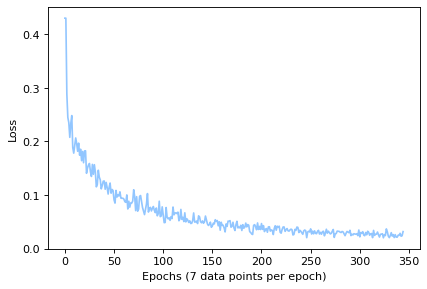

In [36]:
if not parameters['reload']:
    values = []
    for i in losses:
      values.append(i.item())
    plt.plot(values)
    plt.xlabel('Epochs (7 data points per epoch)')
    plt.ylabel('Loss')
    plt.show()

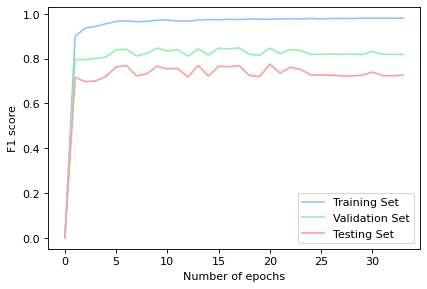

In [37]:
train_F1_scores = []
val_F1_scores = []
test_F1_scores = []

if not parameters['reload']:
    for scores in all_F:
        train_F1_scores.append(scores[0])
        val_F1_scores.append(scores[1])
        test_F1_scores.append(scores[2])

    plt.plot(train_F1_scores, label='Training Set')
    plt.plot(val_F1_scores, label='Validation Set')
    plt.plot(test_F1_scores, label='Testing Set')

    plt.legend()
    plt.xlabel('Number of epochs')
    plt.ylabel('F1 score')

    plt.show()

### Model Testing

This is where we provide our readers with some fun, they can try out how the trained model functions on the sentences that you throw at it. Feel free to play around.


##### LIVE: PRODUCTION!

In [38]:
model_testing_sentences = ['Jay is from India','Donald is the president of USA','Grace bought an iPhone from Apple','We are students from NTU']

#parameters
lower=parameters['lower']

#preprocessing
final_test_data = []
for sentence in model_testing_sentences:
    s=sentence.split()
    str_words = [w for w in s]
    words = [word_to_id[lower_case(w,lower) if lower_case(w,lower) in word_to_id else '<UNK>'] for w in str_words]
    
    # Skip characters that are not in the training set
    chars = [[char_to_id[c] for c in w if c in char_to_id] for w in str_words]
    
    final_test_data.append({
        'str_words': str_words,
        'words': words,
        'chars': chars,
    })

#prediction
predictions = []
print("Prediction:")
print("word : tag")
for data in final_test_data:
    words = data['str_words']
    chars2 = data['chars']

    d = {} 
    
    # Padding the each word to max word size of that sentence
    chars2_length = [len(c) for c in chars2]
    char_maxl = max(chars2_length)
    chars2_mask = np.zeros((len(chars2_length), char_maxl), dtype='int')
    for i, c in enumerate(chars2):
        chars2_mask[i, :chars2_length[i]] = c
    chars2_mask = Variable(torch.LongTensor(chars2_mask))

    dwords = Variable(torch.LongTensor(data['words']))

    # We are getting the predicted output from our model
    if use_gpu:
        val,predicted_id = model(dwords.cuda(), chars2_mask.cuda(), chars2_length, d)
    else:
        val,predicted_id = model(dwords, chars2_mask, chars2_length, d)

    pred_chunks = get_chunks(predicted_id,tag_to_id)
    temp_list_tags=['NA']*len(words)
    for p in pred_chunks:
        temp_list_tags[p[1]]=p[0]
        
    for word,tag in zip(words,temp_list_tags):
        print(word,':',tag)
    print('\n')

Prediction:
word : tag
Jay : PER
is : NA
from : NA
India : LOC


Donald : PER
is : NA
the : NA
president : NA
of : NA
USA : LOC


Grace : NA
bought : NA
an : NA
iPhone : NA
from : NA
Apple : ORG


We : NA
are : NA
students : NA
from : NA
NTU : LOC




### References

1) Xuezhe Ma and Eduard Hovy. 2016. ** End-to-end Sequence Labeling via Bi-directional LSTM-CNNs-CRF .** In Proceedings of the 54th Annual Meeting of the Association for Computational Linguistics (Volume 1: LongPapers). Association for Computational Linguistics, Berlin, Germany ** (https://arxiv.org/pdf/1603.01354.pdf) **

2) Official PyTorch Tutorial : [** Advanced: Making Dynamic Decisions and the Bi-LSTM CRF **](http://pytorch.org/tutorials/beginner/nlp/advanced_tutorial.html#sphx-glr-beginner-nlp-advanced-tutorial-py)

3) [** Sequence Tagging with Tensorflow **](https://guillaumegenthial.github.io/sequence-tagging-with-tensorflow.html)  using bi-LSTM + CRF with character embeddings for NER and POS by Guillaume Genthial

4) Github Repository - [** Reference Github Repository **](https://github.com/jayavardhanr/End-to-end-Sequence-Labeling-via-Bi-directional-LSTM-CNNs-CRF-Tutorial)
